In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pickle
from scripts.data_visualiser import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from Pipeline.pre_processing_pipeline import *
import numpy as np
import preprocessing_config as config

In [19]:
image_path = '/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/1100x1100/1100_all_bands_scl.pkl'
sentinel_image = load_single_image(image_path)

mask_path = '/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/1100x1100/1100_fieldmask.pkl'
mask = load_single_image(mask_path)

In [20]:
sentinel_image.shape

(1100, 1100, 11)

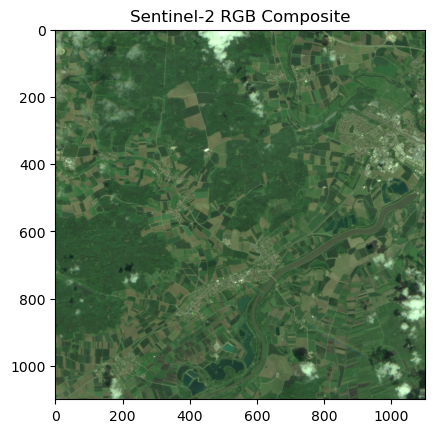

In [13]:
visualise_rgb(sentinel_image)

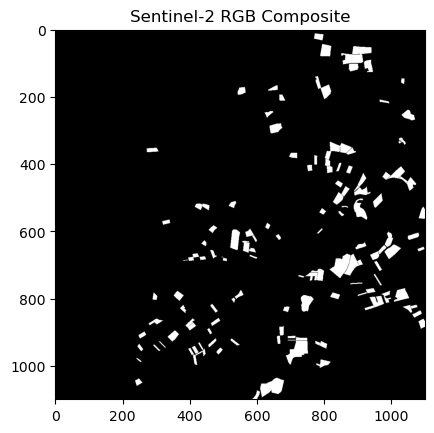

In [14]:
visualise_rgb(mask)

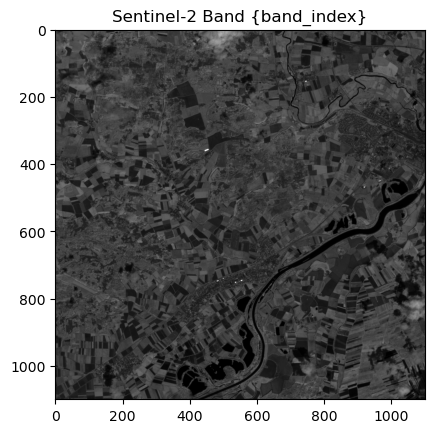

In [15]:
band_index = 6
visualise_single_band(sentinel_image, band_index)

### Adding Masks as a new channel

In [16]:
images = [sentinel_image]
masks = [mask]
new_images = integrate_sugarbeet_mask(images, masks)
new_images[0].shape

TypeError: integrate_sugarbeet_mask() missing 1 required positional argument: 'id_masks'

In [17]:
visualise_all_bands(new_images[0])

NameError: name 'new_images' is not defined

### Masking Pixels that are clouded and pixels that don't belong to Sugar-beet fields

In [18]:
masked_images = mask_images(new_images)

NameError: name 'new_images' is not defined

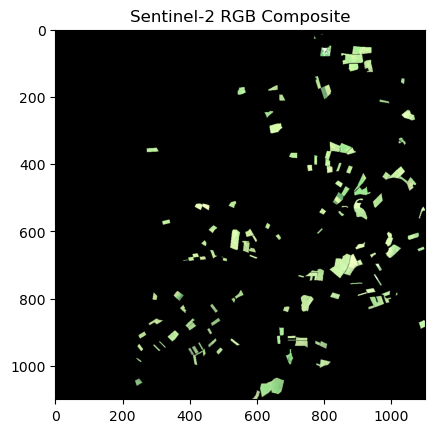

In [ ]:
visualise_rgb(masked_images[0])

### Extracting Fields / Patches

In [ ]:
image_patches = extract_fields(masked_images, config.field_size)
print("Number of patches for image 0: ", len(image_patches[0]))

--- 108 sugar-beet fields extracted for image 0
Number of patches for image 0:  108


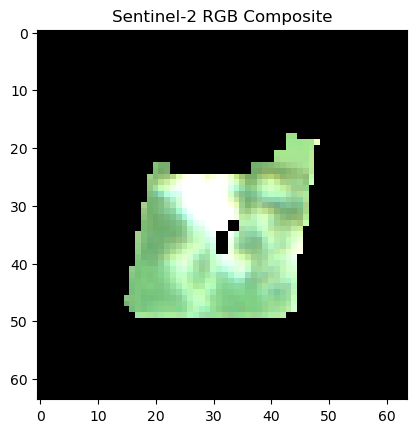

In [ ]:
visualise_rgb(image_patches[0][1])

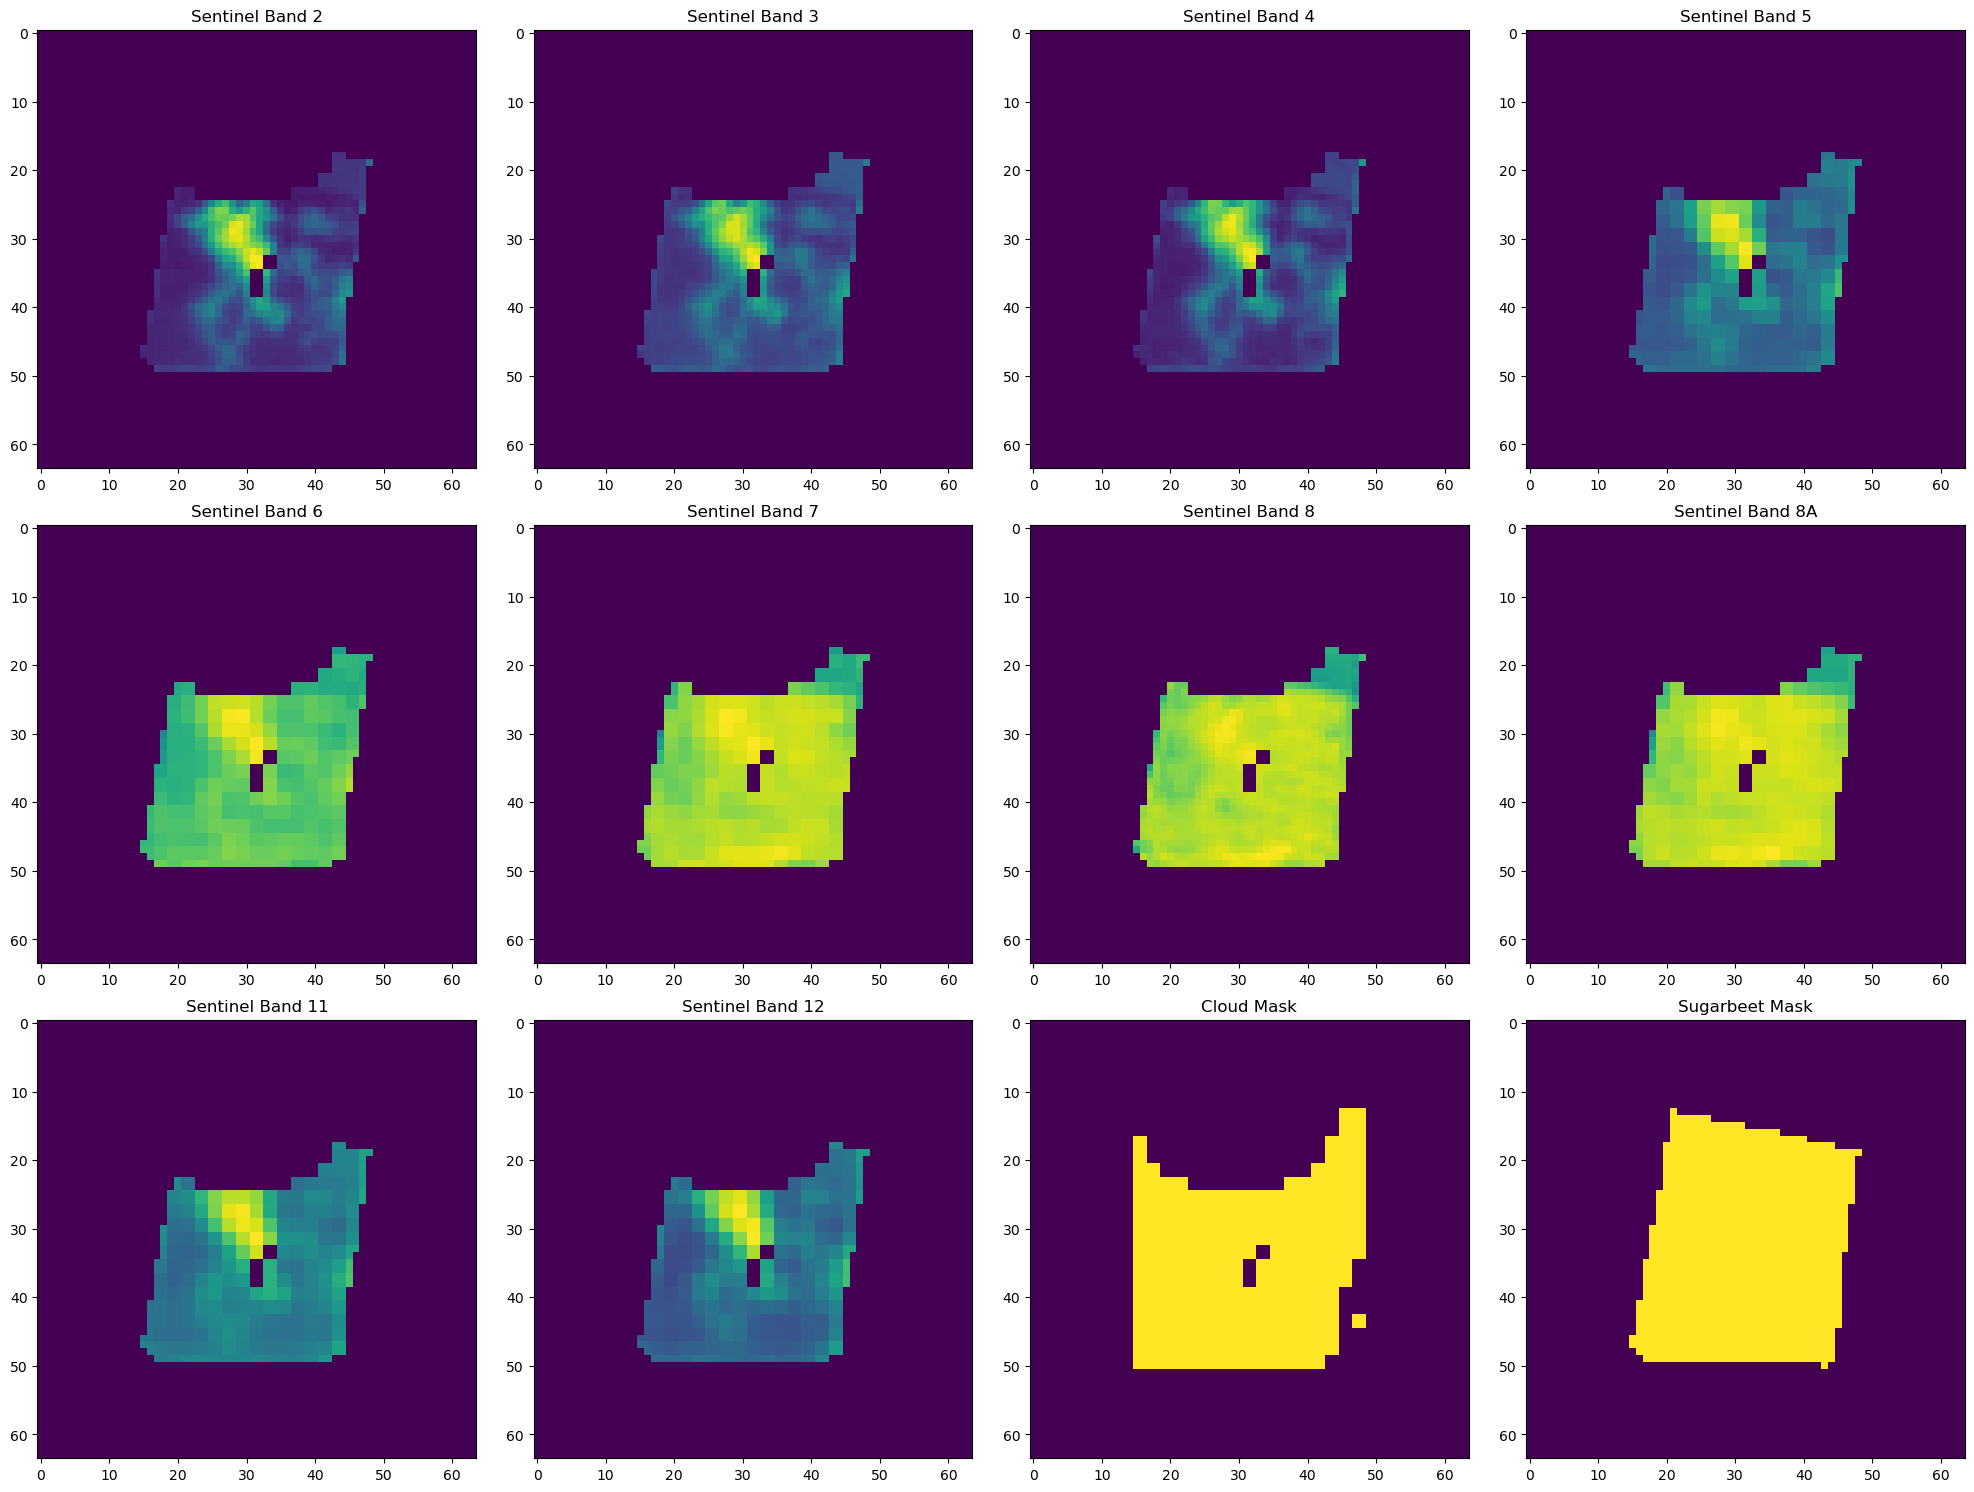

In [ ]:
visualise_all_bands(image_patches[0][1])    #2nd patch of 1st image

In [ ]:
x = image_patches[0][1]
x[30][45][1]

0.0585

### Saving Image Patches

In [ ]:
fields_base_directory = '/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Master-Thesis-Github/Master-Thesis/Data-Preprocessing/Data'
train_test_ratio = 0.75
success = save_field_images(fields_base_directory, image_patches, train_test_ratio)

In [ ]:
image1_patch1 = load_single_image('Data/train/train_image1_patch2.pkl')

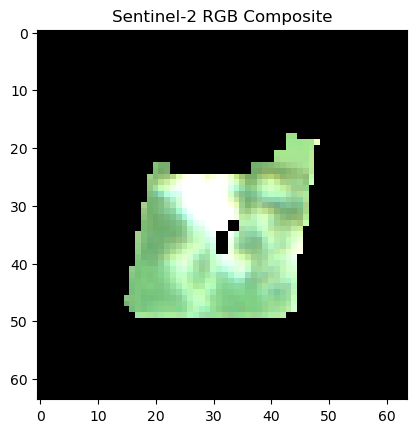

In [ ]:
visualise_rgb(image1_patch1)

## Pre-processing Pipeline

In [ ]:
pipeline = PreProcessingPipeline()

In [ ]:
pipeline.run_full_preprocessing_pipeline()

Sugar-beet fields and masks are loaded successfully! Great start! Shape of the image is:  (1100, 1100, 11)

Masks are combined with the images successfully! The shape of image is now:  (1100, 1100, 12)

Masking pixels that are cloud-covered or that don't belong to sugarbeet fields ... 
--- 1161327 pixels masked in image 0
Successfully gotten rid of unwanted pixels!

Extracting sugar-beet fields from images ...
--- 108 sugar-beet fields extracted for image 0
Fields extracted!

Train and Test Dataset created for modelling! Pre-processing pipeline finished!


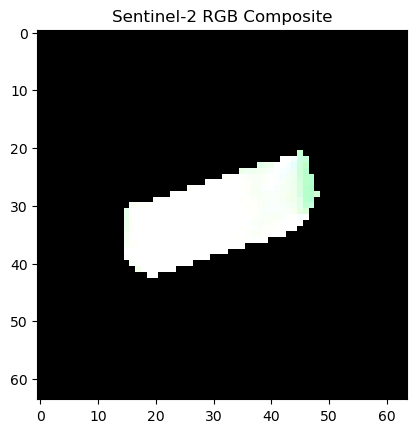

In [ ]:
image_path = '/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Master-Thesis-Github/Master-Thesis/Data-Preprocessing/Data/train/train_image1_patch44.pkl'
test_image_sample = load_single_image(image_path)
visualise_rgb(test_image_sample)

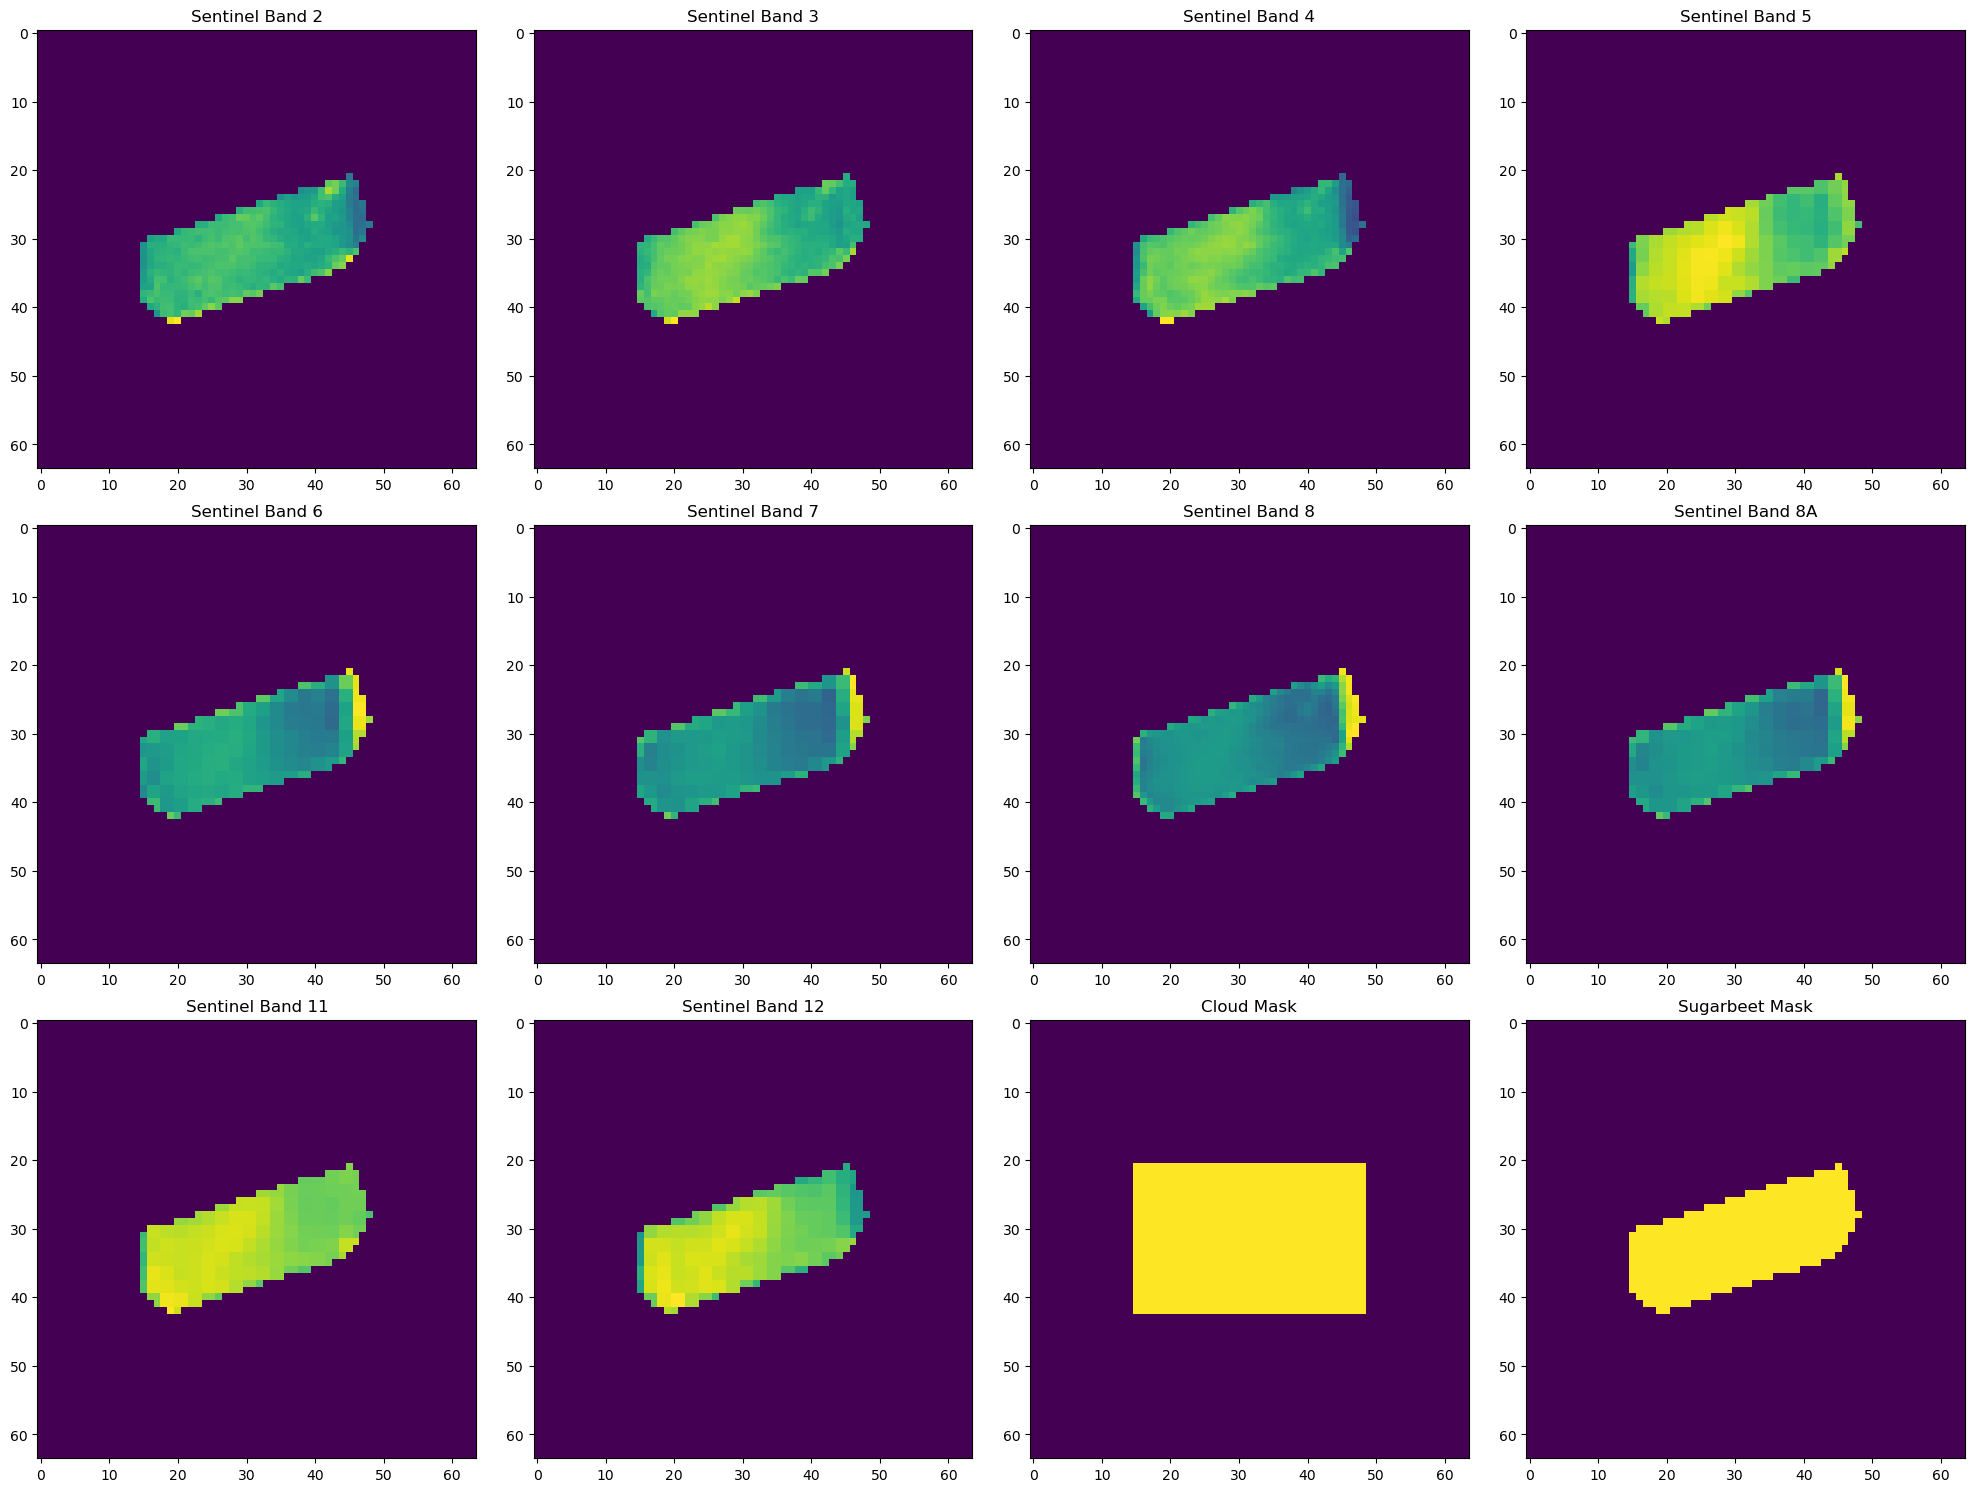

In [ ]:
visualise_all_bands(test_image_sample)

In [ ]:
test_image_sample = masked_images[0]

nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4

np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape

(1100, 1100)

In [ ]:
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape

(1100, 1100, 14)

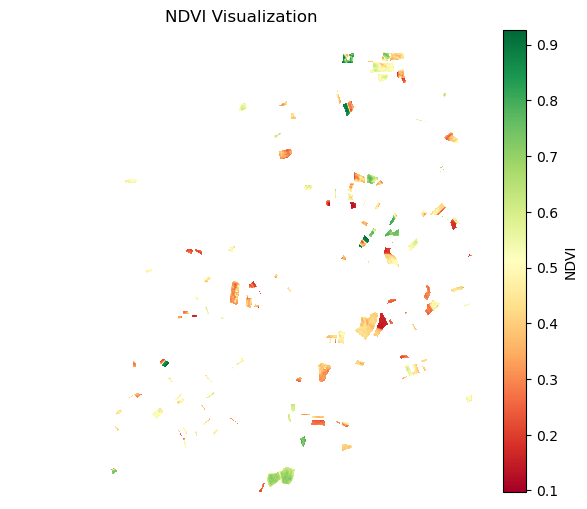

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()

### Average NDVI for all fields in the Image

In [ ]:
sentinel_images, sugarbeet_masks, id_masks = load_sentinel_images(config.sentinel_image_directory, config.sentinel_mask_directory, config.sentinel_id_directory)

integrated_images = integrate_sugarbeet_mask(sentinel_images, sugarbeet_masks, id_masks)

masked_images = mask_images(integrated_images)

extracted_patches = extract_fields(masked_images, config.field_size)


--- 1161327 pixels masked in image 0
--- 108 sugar-beet fields extracted for image 0


### NDVI

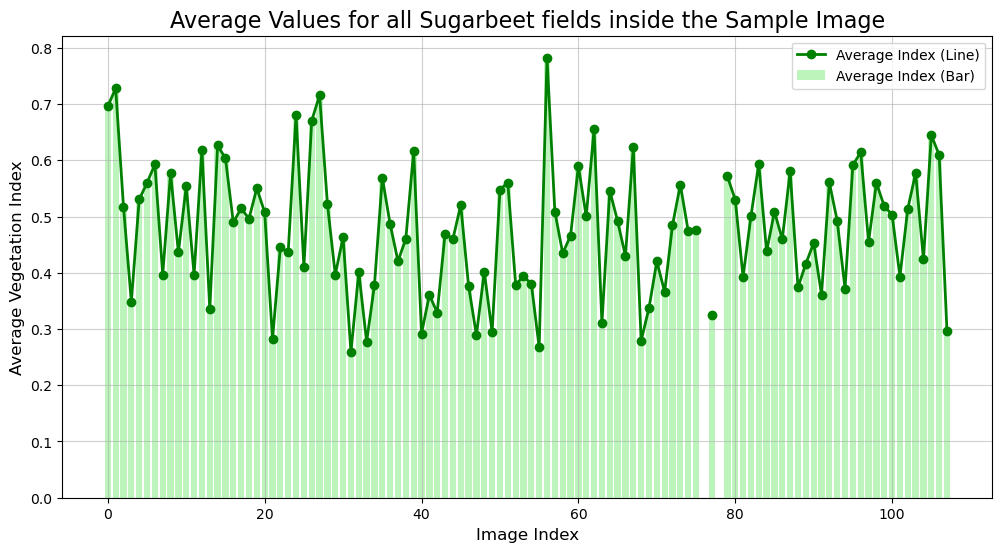

In [ ]:
results_ndvi, results_ari1, results_ari2, results_mcai = get_average_indices(extracted_fields)

plot_index_image(results_ndvi[0])


### Average mCAI

The Modified Chlorophyll Absorption Integral (mCAI) is a vegetation index that measures the absorption area in the red region (650–700 nm), primarily associated with chlorophyll content. Its values depend on how much light is absorbed or reflected in this range:

- Healthy Vegetation (High mCAI): Pixels appear dark green or blue, reflecting high chlorophyll absorption.
- Stressed Vegetation (Low mCAI): Pixels appear yellow, orange, or red, reflecting low absorption and higher reflectance.
- Non-Vegetative Surfaces: Areas like soil or water may have mCAI close to 0 and appear in light colors (e.g., white, light yellow).

In [9]:
results_ndvi, results_ari1, results_ari2, results_mcai = get_average_indices(extracted_fields)

plot_index_image(results_mcai[0])

NameError: name 'extracted_fields' is not defined

In [8]:
image_path = '/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Master-Thesis-Github/Master-Thesis/Data-Preprocessing/Data/train/train_image1_patch2.pkl'
test_image_sample = masked_images[0]
#test_image_sample = load_single_image(image_path)


valid_pixels = np.any(test_image_sample[:, :, :10] > 0, axis=2)  #Valid if any band is >0
invalid_mask = ~valid_pixels  # Black or invalid pixels
mcai = np.mean(1 - test_image_sample[:, :, 4:6], axis=2)  #Bands 6–7 (Red Edge 2–3)
mcai[invalid_mask] = np.nan
mcai = np.clip(mcai, -1, 1)

NameError: name 'masked_images' is not defined

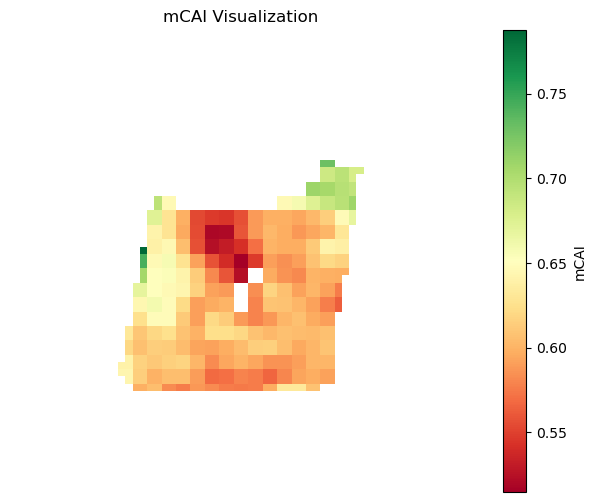

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(mcai, cmap='RdYlGn')  # Use color map to visualize mCAI
plt.colorbar(label='mCAI')
plt.title('mCAI Visualization')
plt.axis('off')  # Hide axis
plt.show()

### ID Mask???

In [ ]:
sentinel_images, sugarbeet_masks, id_masks = load_sentinel_images(config.sentinel_image_directory, config.sentinel_mask_directory, config.sentinel_id_directory)

In [ ]:
np.unique(id_masks[0])

array([       0., 16675150., 16675320., 16679350., 16679370., 16679540.,
       16685740., 16685750., 16685770., 16685780., 16685790., 16685830.,
       16685870., 16685890., 16685900., 16685910., 16685920., 16685970.,
       16685980., 16685990., 16686000., 16686020., 16686050., 16686070.,
       16686080., 16686090., 16686100., 16686340., 16686350., 16686360.,
       16686370., 16686380., 16686390., 16686400., 16686410., 16686420.,
       16686430., 16686440., 16686500., 16686510., 16686520., 16686530.,
       16686540., 16686570., 16686580., 16686590., 16686600., 16686610.,
       16686620., 16686630., 16686640., 16686650., 16686660., 16686670.,
       16686680., 16686730., 16686900., 16687000., 16687070., 16687080.,
       16687090., 16687100., 16687110., 16687120., 16687700., 16688910.,
       16688930., 16688940., 16688980., 16688990., 16689160., 16689320.,
       16689330., 16689380., 16689440., 16689460., 16694180., 16694190.,
       16694200., 16694220., 16694230., 16694240., 

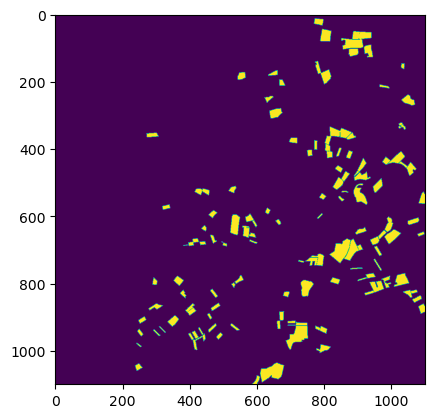

In [ ]:
plt.imshow(id_masks[0])

### Vegetation Indices:

- NDVI (Normalized Difference Vegetation Index): General vegetation health.
- ARI1/ARI2 (Anthocyanin Reflectance Index): Useful for detecting anthocyanin content, indicating stress or senescence.
- SAVI (Soil-Adjusted Vegetation Index): Accounts for soil reflectance, especially in sparse vegetation.
- EVI (Enhanced Vegetation Index): More sensitive to canopy structure, reduces soil background effects.
- mCAI (Modified Chlorophyll Absorption Integral): Indicates chlorophyll absorption in the 650–700 nm range.
- RDVI (Renormalized Difference Vegetation Index): Reduces saturation effects in dense vegetation.
- MSAVI (Modified Soil-Adjusted Vegetation Index): Improves sensitivity in regions with moderate vegetation cover.
- CIgreen (Chlorophyll Index Green): Indicates chlorophyll content using the green band.
- GNDVI (Green NDVI): Similar to NDVI but uses green reflectance for sensitivity to chlorophyll.

### ARI1 and ARI2

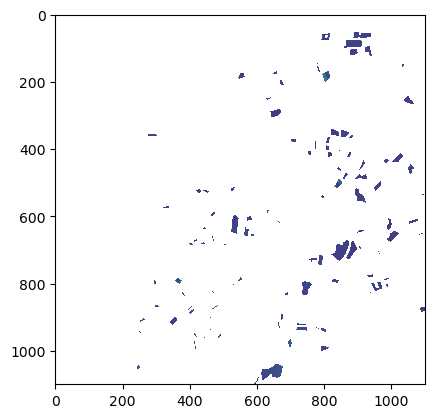

In [ ]:
image = test_image_sample
r550 = image[:, :, 1]   #Band at 550 nm (Green)
r700 = image[:, :, 3]   #Band at 700 nm (Red edge)
r800 = image[:, :, 6]   #Band at 800 nm (Near-Infrared)

ari1 = (1 / r550) - (1 / r700)
ari2 = (r800 / r550) - (r800 / r700)

plt.imshow(ari1)

In [ ]:
sentinel_images, sugarbeet_masks, id_masks = load_sentinel_images(config.sentinel_image_directory, config.sentinel_mask_directory, config.sentinel_id_directory)

integrated_images = integrate_sugarbeet_mask(sentinel_images, sugarbeet_masks, id_masks)

masked_images = mask_images(integrated_images)

extracted_fields = extract_fields(masked_images, config.field_size)

--- 1161327 pixels masked in image 0
--- 108 sugar-beet fields extracted for image 0


In [ ]:
modified_images = images_vegetation_indices(extracted_fields)

In [ ]:
modified_images[0][0].shape

(64, 64, 17)

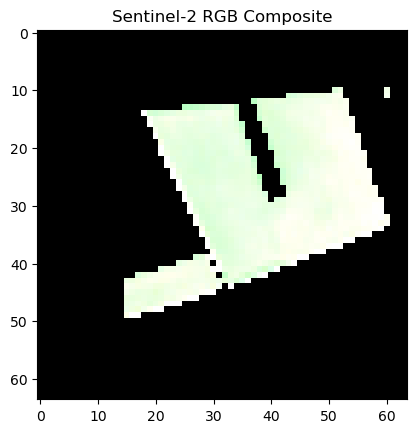

In [ ]:
visualise_rgb(modified_images[0][72])

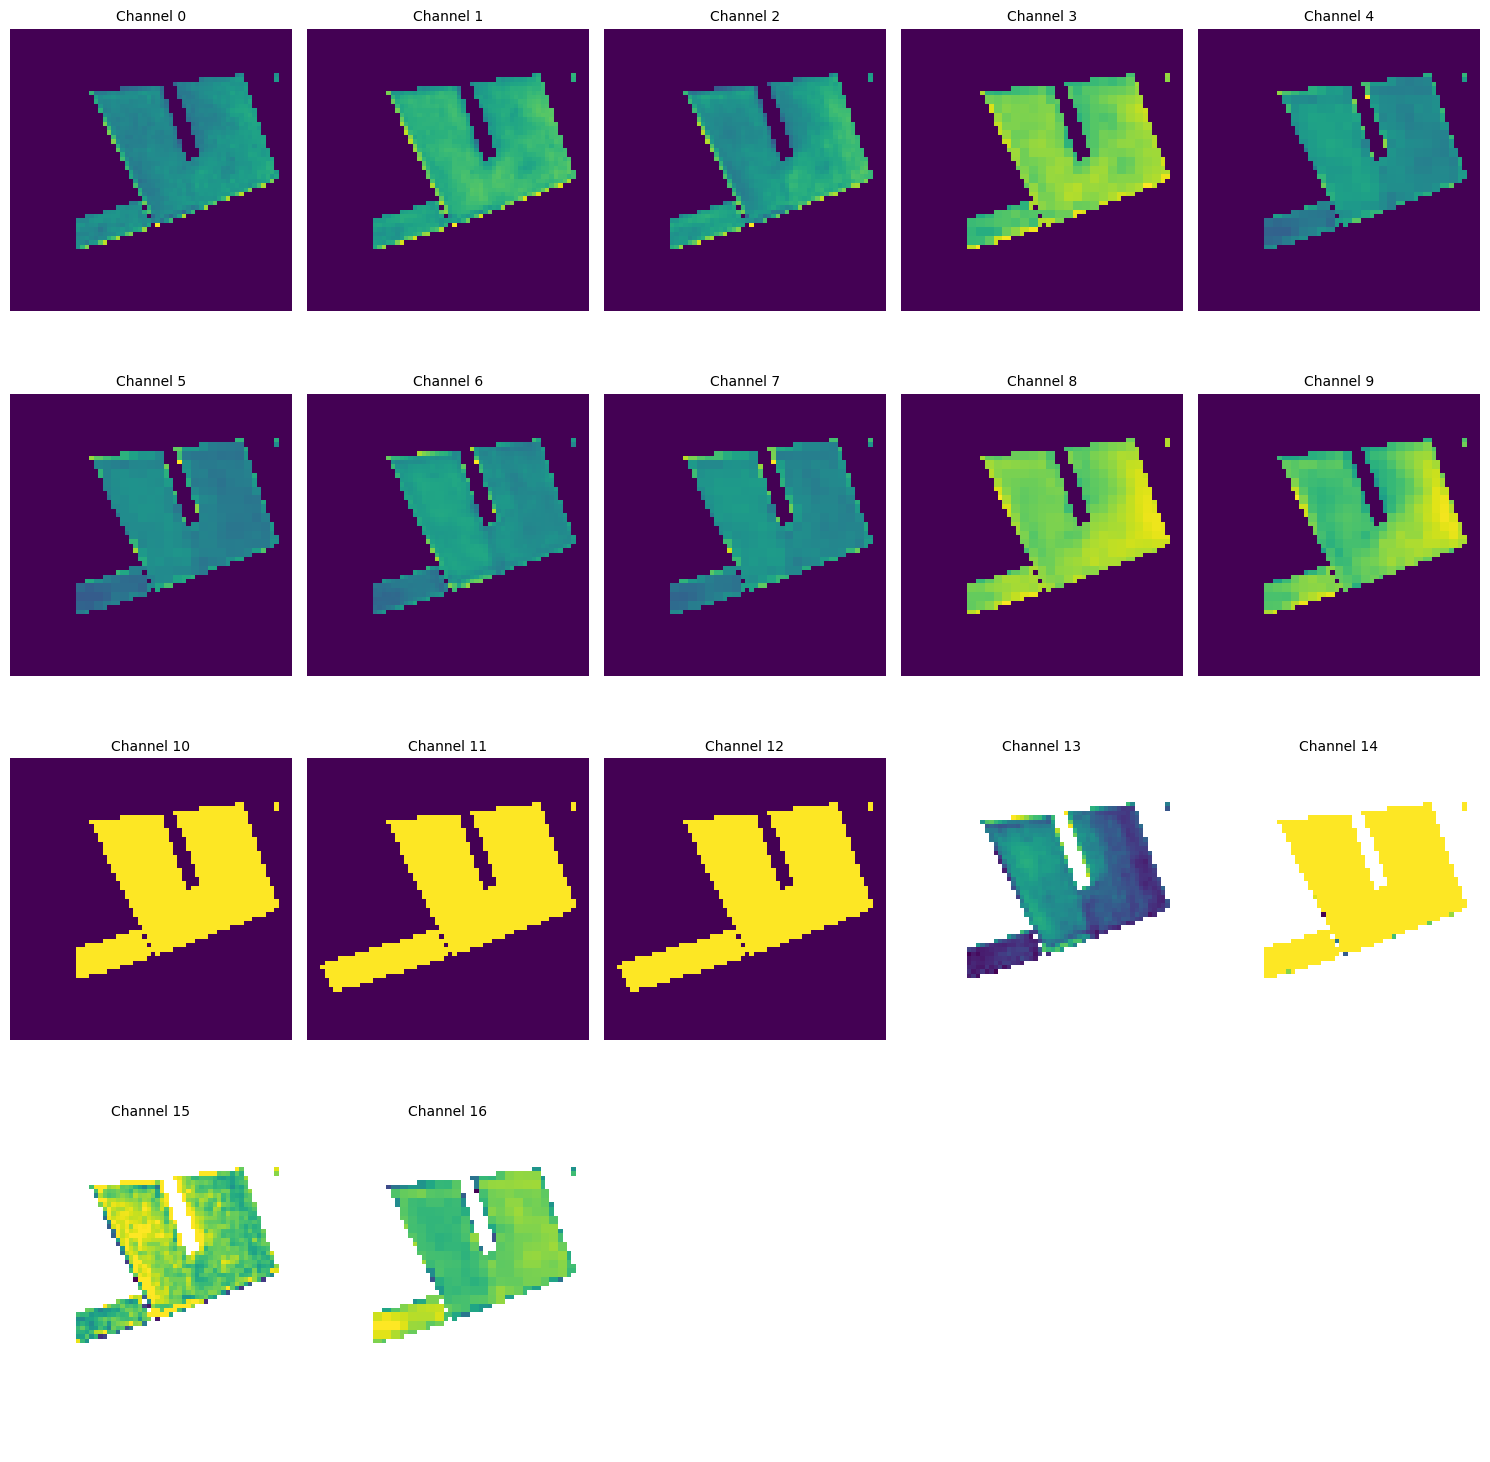

In [ ]:
visualize_image_channels(modified_images[0][72])

In [ ]:
len(results_ndvi[0])

108

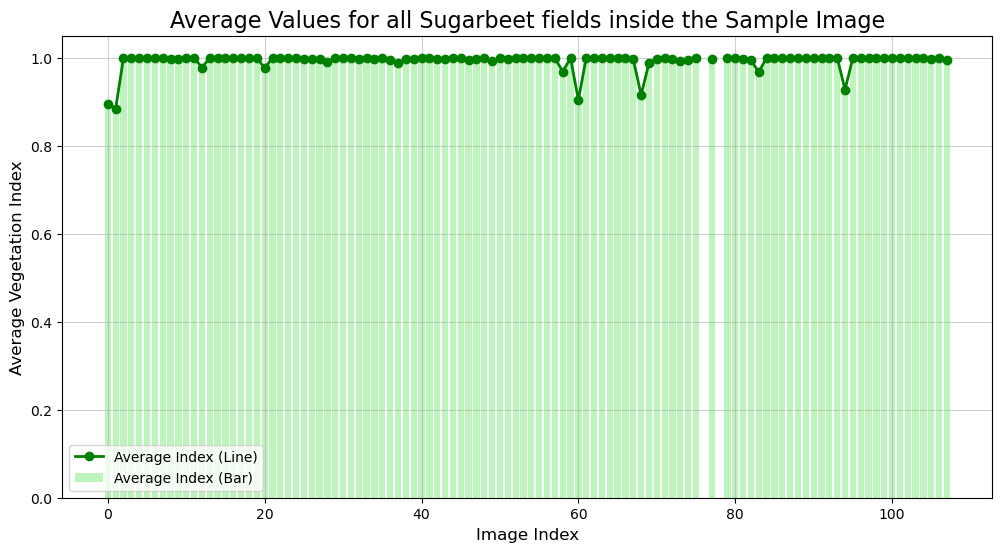

In [ ]:
results_ndvi, results_ari1, results_ari2, results_mcai = get_average_indices(extracted_fields)

plot_index_image(results_ari1[0])

## 2019 Sample

### Importing Excel

In [ ]:
import pandas as pd

file_path = '/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/labels-2019.xlsx'
data = pd.read_excel(file_path)
data['SBR'].value_counts()

SBR
yes    37
no     28
Name: count, dtype: int64

In [ ]:
data = data.to_numpy()
data[0][1]

'yes'

## Image 1 - Disease

In [ ]:
path1='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/2019_07_29_all_bands_scl.pkl'
image = load_single_image(path1)
image.shape


(11, 1000, 1000)

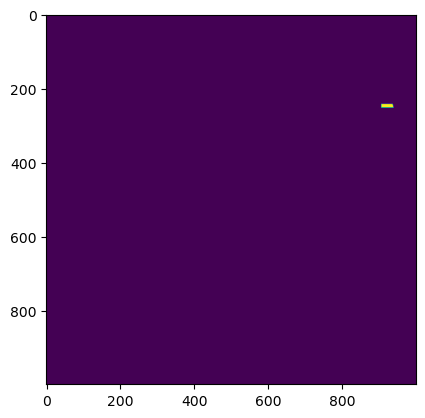

In [ ]:
sb_mask='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/fieldmask.pkl'
sbmask = load_single_image(sb_mask)
plt.imshow(sbmask)

In [ ]:
transposed_data = np.transpose(image, (2, 1, 0))
transposed_data.shape

(1000, 1000, 11)

### Second Image

In [ ]:
path2='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/2019_08_18_all_bands_scl.pkl'
image2 = load_single_image(path2)
image2.shape

(11, 1000, 1000)

In [ ]:
transposed_data1 = np.transpose(image2, (2, 1, 0))
transposed_data1.shape

(1000, 1000, 11)

In [ ]:
fn = load_single_image('/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/field_number.pkl')
fn = np.expand_dims(fn, axis=2)
sbmask = np.expand_dims(sbmask, axis=2)
sbmask.shape

(1000, 1000, 1)

In [ ]:
fn.shape

(1000, 1000, 1)

In [ ]:
sentinel_images = [transposed_data, transposed_data1]
sugarbeet_masks = [sbmask, sbmask]
fnl = [fn, fn]
integrated_images = integrate_sugarbeet_mask(sentinel_images, sugarbeet_masks, fnl)
masked_images = mask_images(integrated_images)
extracted_patches = extract_fields(masked_images, (64,64))

--- 999679 pixels masked in image 0
--- 999679 pixels masked in image 1
--- 1 sugar-beet fields extracted for image 0
--- 1 sugar-beet fields extracted for image 1


### NDVI of 29th July image

In [ ]:
test_image_sample = extracted_patches[0][0]

nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4

np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape

(64, 64)

In [ ]:
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape

(64, 64, 14)

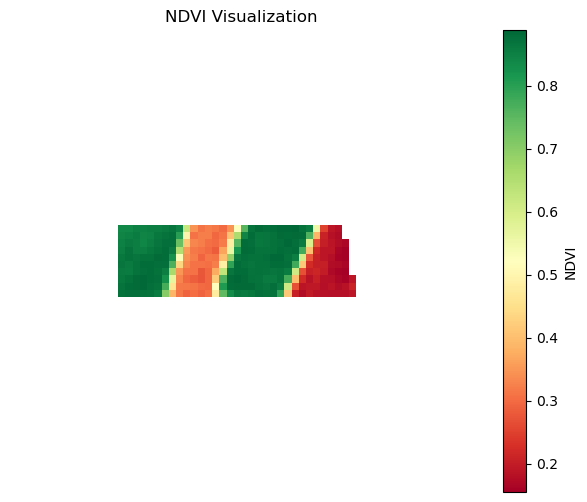

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()

### NDVI of 18th August Image

In [ ]:
test_image_sample = extracted_patches[1][0]

nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4

np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape

(64, 64)

In [ ]:
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape

(64, 64, 14)

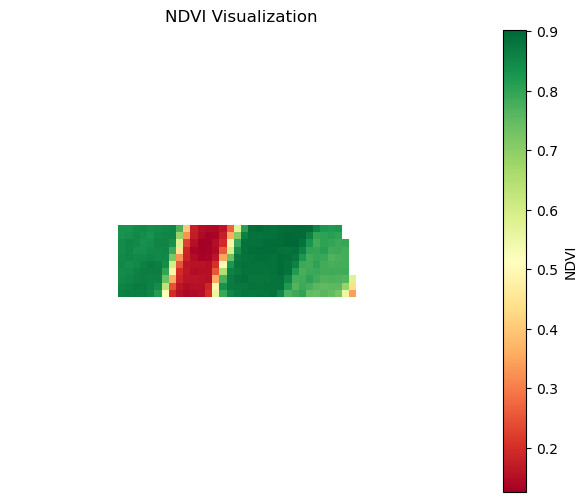

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
np.max(extracted_patches[0][0][:,:,12])

1230818.0

## Image 2 - No Disease (32UMV_7_6)

In [ ]:
path3='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/2019_08_03_all_bands_scl1.pkl'
path4='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/2019_08_28_all_bands_scl.pkl'
image3 = load_single_image(path3)
image4 = load_single_image(path4)
image3.shape

(11, 1000, 1000)

In [ ]:
transposed_data3 = np.transpose(image3, (2, 1, 0))
transposed_data4 = np.transpose(image4, (2, 1, 0))
transposed_data3.shape

(1000, 1000, 11)

In [ ]:
mask3='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/fieldmask6.pkl'
fn3 = '/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/field_number6.pkl'
mask3 = load_single_image(mask3)
fn3 = load_single_image(fn3)
mask3.shape

(1000, 1000)

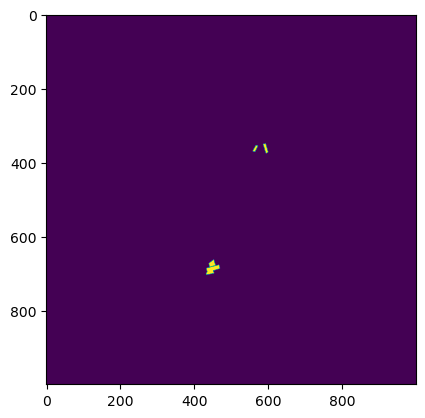

In [ ]:
plt.imshow(mask3)

In [ ]:
fn3 = np.expand_dims(fn3, axis=2)
mask3 = np.expand_dims(mask3, axis=2)

In [ ]:
np.unique(fn3)

array([      0, 1179855, 1187336, 1196347, 1217498], dtype=int32)

In [ ]:
sentinel_images = [transposed_data3, transposed_data4]
sugarbeet_masks = [mask3, mask3]
fnl = [fn3, fn3]
integrated_images = integrate_sugarbeet_mask(sentinel_images, sugarbeet_masks, fnl)
masked_images = mask_images(integrated_images)
extracted_patches = extract_fields(masked_images, (64,64))

--- 999518 pixels masked in image 0
--- 999005 pixels masked in image 1
--- 3 sugar-beet fields extracted for image 0
--- 3 sugar-beet fields extracted for image 1


### 26th July Image - No disease

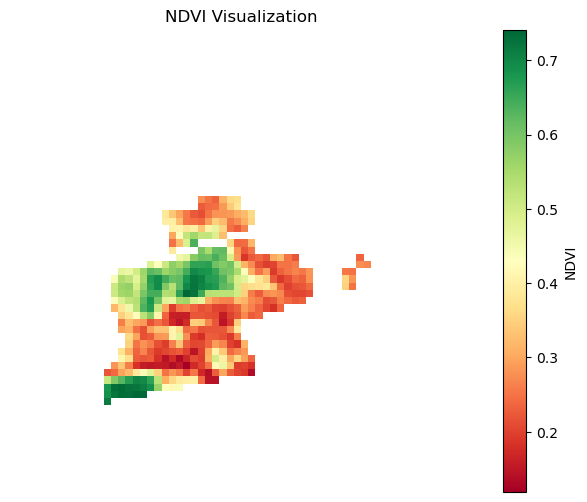

In [ ]:
test_image_sample = extracted_patches[0][2]
nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4
np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()

### 9th September Image - No disease

In [ ]:
np.unique(test_image_sample[:,:,12])

array([      0., 1179855., 1187336.])

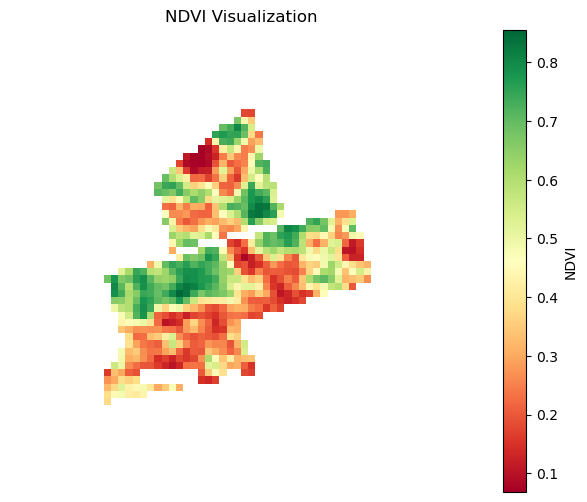

In [ ]:
test_image_sample = extracted_patches[1][2]
nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4
np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()

## Image 3 - No Disease

In [ ]:
path5='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/2019_08_25_all_bands_scl.pkl'
path6='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/2019_09_12_all_bands_scl1.pkl'
image5 = load_single_image(path5)
image6 = load_single_image(path6)
image5.shape

(11, 1000, 1000)

In [ ]:
transposed_data5 = np.transpose(image5, (2, 1, 0))
transposed_data6 = np.transpose(image6, (2, 1, 0))
transposed_data3.shape

(1000, 1000, 11)

In [ ]:
mask5='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/fieldmask5.pkl'
fn5 = '/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/field_number5.pkl'
mask5 = load_single_image(mask5)
fn5 = load_single_image(fn5)
mask5.shape

(1000, 1000)

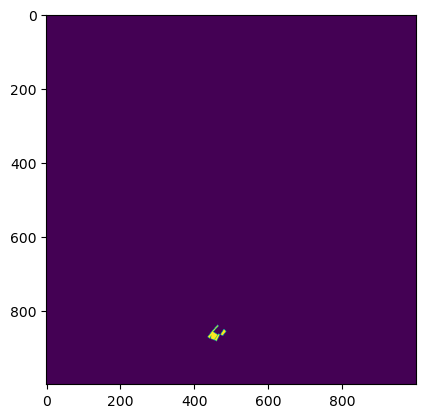

In [ ]:
plt.imshow(mask5)

In [ ]:
fn5 = np.expand_dims(fn5, axis=2)
mask5 = np.expand_dims(mask5, axis=2)

In [ ]:
np.unique(fn5)

array([      0, 1177490, 1183928], dtype=int32)

In [ ]:
sentinel_images = [transposed_data5, transposed_data6]
sugarbeet_masks = [mask5, mask5]
fnl = [fn5, fn5]
integrated_images = integrate_sugarbeet_mask(sentinel_images, sugarbeet_masks, fnl)
masked_images = mask_images(integrated_images)
extracted_patches = extract_fields(masked_images, (64,64))

--- 999613 pixels masked in image 0
--- 999401 pixels masked in image 1
--- 2 sugar-beet fields extracted for image 0
--- 2 sugar-beet fields extracted for image 1


### 3rd August Image - No Disease

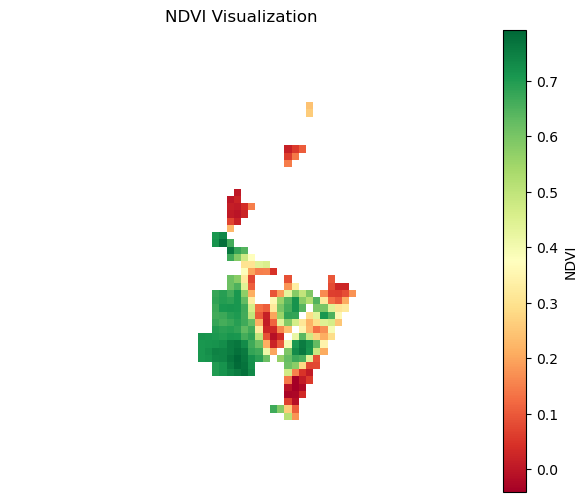

In [ ]:
test_image_sample = extracted_patches[0][0]
nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4
np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
np.unique(test_image_sample[:,:,12])

array([      0., 1177490., 1183928.])

### 4th September Image - No Disease

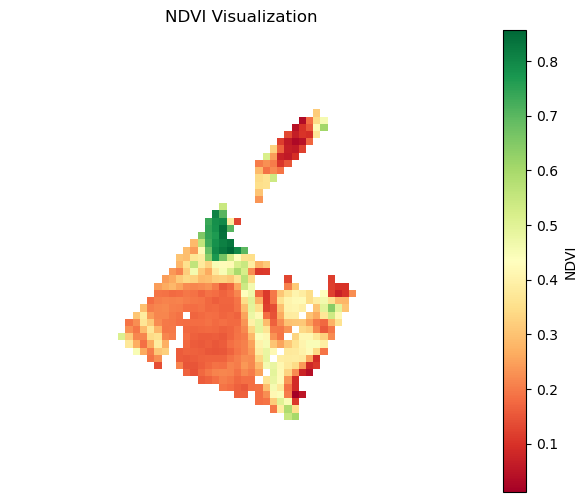

In [ ]:
test_image_sample = extracted_patches[1][0]
nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4
np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()

## Image 4 - 32UMV_9_4

In [ ]:
path5='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/2019_08_08_all_bands_scl.pkl'
path6='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/2019_09_12_all_bands_scl7.pkl'
image5 = load_single_image(path5)
image6 = load_single_image(path6)
image5.shape

(11, 1000, 1000)

In [ ]:
transposed_data5 = np.transpose(image5, (2, 1, 0))
transposed_data6 = np.transpose(image6, (2, 1, 0))
transposed_data3.shape

(1000, 1000, 11)

In [ ]:
mask5='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/fieldmask9.pkl'
fn5 = '/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/field_number9.pkl'
mask5 = load_single_image(mask5)
fn5 = load_single_image(fn5)
mask5.shape

(1000, 1000)

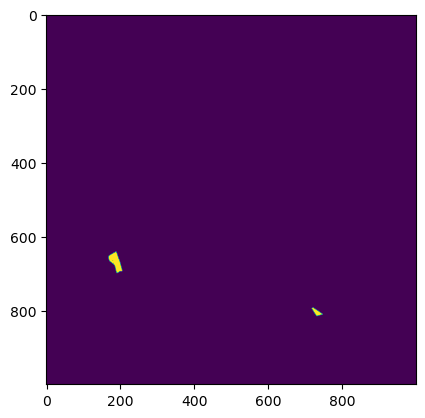

In [ ]:
plt.imshow(mask5)

In [ ]:
fn5 = np.expand_dims(fn5, axis=2)
mask5 = np.expand_dims(mask5, axis=2)

In [ ]:
np.unique(fn5)

array([      0, 1182822, 1216964, 1225397], dtype=int32)

In [ ]:
sentinel_images = [transposed_data5, transposed_data6]
sugarbeet_masks = [mask5, mask5]
fnl = [fn5, fn5]
integrated_images = integrate_sugarbeet_mask(sentinel_images, sugarbeet_masks, fnl)
masked_images = mask_images(integrated_images)
extracted_patches = extract_fields(masked_images, (64,64))

--- 999237 pixels masked in image 0
--- 998655 pixels masked in image 1
--- 2 sugar-beet fields extracted for image 0
--- 2 sugar-beet fields extracted for image 1


### 10th August Image - No Disease

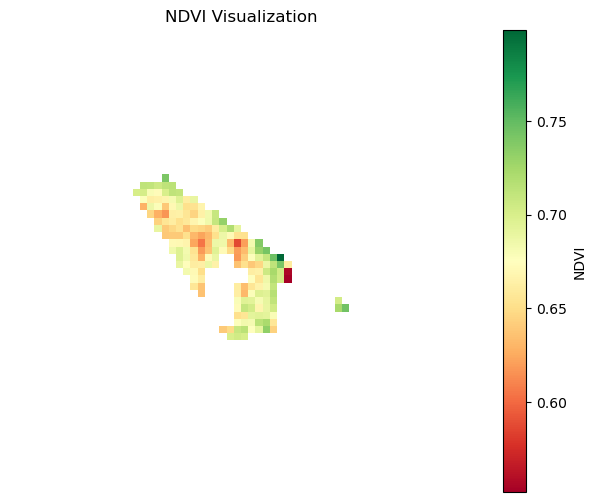

In [ ]:
test_image_sample = extracted_patches[0][1]
nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4
np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
np.unique(test_image_sample[:,:,12])

array([      0., 1225397.])

### 9th September Image - No Disease

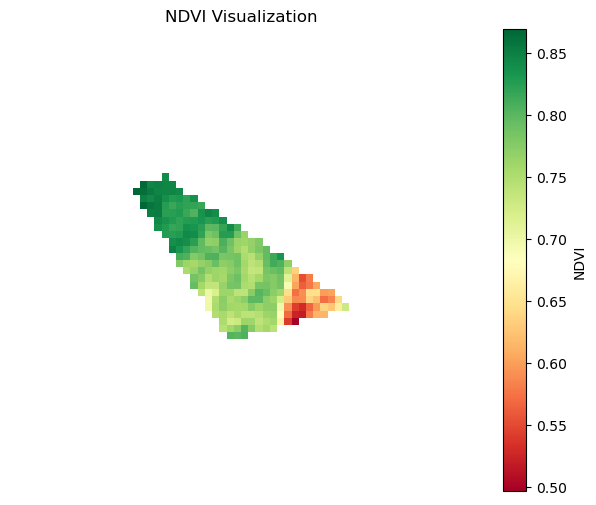

In [ ]:
test_image_sample = extracted_patches[1][1]
nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4
np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()

## Image 5 - 32_UNV_4_4

In [ ]:
path5='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/2019_06_09_all_bands_scl.pkl'
path6='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/2019_07_16_all_bands_scl.pkl'
image5 = load_single_image(path5)
image6 = load_single_image(path6)
image5.shape

(11, 1000, 1000)

In [ ]:
transposed_data5 = np.transpose(image5, (2, 1, 0))
transposed_data6 = np.transpose(image6, (2, 1, 0))
transposed_data3.shape

(1000, 1000, 11)

In [ ]:
mask5='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/fieldmask4.pkl'
fn5 = '/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/field_number4.pkl'
mask5 = load_single_image(mask5)
fn5 = load_single_image(fn5)
mask5.shape

(1000, 1000)

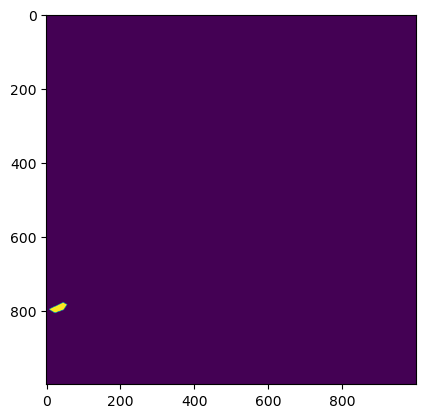

In [ ]:
plt.imshow(mask5)

In [ ]:
fn5 = np.expand_dims(fn5, axis=2)
mask5 = np.expand_dims(mask5, axis=2)

In [ ]:
np.unique(fn5)

array([      0, 1223970], dtype=int32)

In [ ]:
sentinel_images = [transposed_data5, transposed_data6]
sugarbeet_masks = [mask5, mask5]
fnl = [fn5, fn5]
integrated_images = integrate_sugarbeet_mask(sentinel_images, sugarbeet_masks, fnl)
masked_images = mask_images(integrated_images)
extracted_patches = extract_fields(masked_images, (64,64))

--- 999323 pixels masked in image 0
--- 999323 pixels masked in image 1
--- 1 sugar-beet fields extracted for image 0
--- 1 sugar-beet fields extracted for image 1


### 10th August Image - Disease

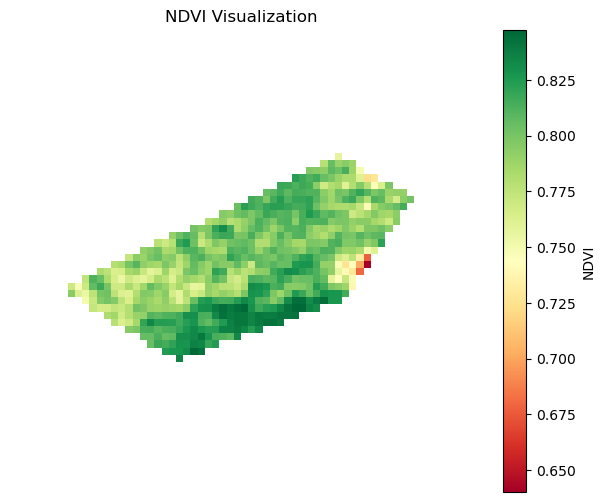

In [ ]:
test_image_sample = extracted_patches[0][0]
nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4
np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
np.unique(test_image_sample[:,:,12])

array([      0., 1223970.])

### 9th September Image - Disease

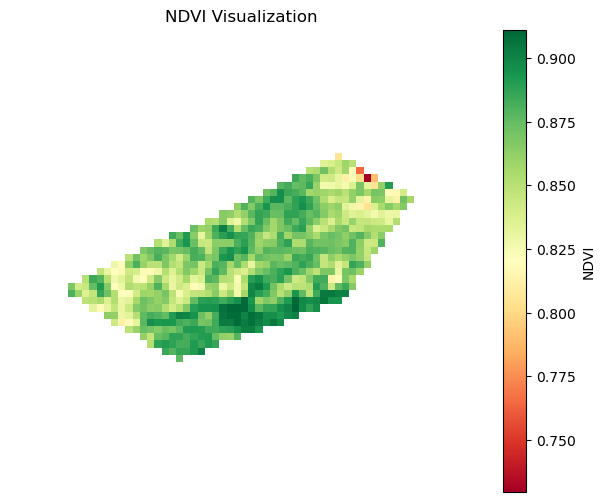

In [ ]:
test_image_sample = extracted_patches[1][0]
nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4
np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()

## Image 6 - 32_UNV_9_9

In [ ]:
path5='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/2019_08_18_all_bands_scl8.pkl'
path6='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/2019_09_02_all_bands_scl8.pkl'
image5 = load_single_image(path5)
image6 = load_single_image(path6)
image5.shape

(11, 1000, 1000)

In [ ]:
transposed_data5 = np.transpose(image5, (2, 1, 0))
transposed_data6 = np.transpose(image6, (2, 1, 0))
transposed_data3.shape

(1000, 1000, 11)

In [ ]:
mask5='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/fieldmask8.pkl'
fn5 = '/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/field_number8.pkl'
mask5 = load_single_image(mask5)
fn5 = load_single_image(fn5)
mask5.shape

(1000, 1000)

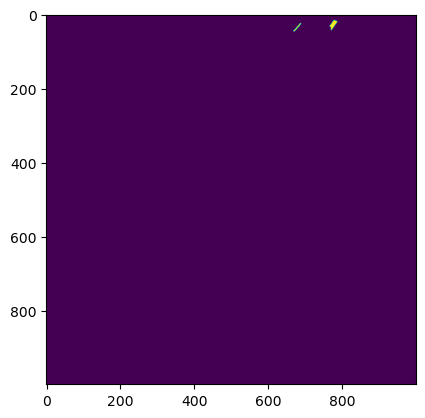

In [ ]:
plt.imshow(mask5)

In [ ]:
fn5 = np.expand_dims(fn5, axis=2)
mask5 = np.expand_dims(mask5, axis=2)

In [ ]:
np.unique(fn5)

array([      0, 1174805, 1226225], dtype=int32)

In [ ]:
sentinel_images = [transposed_data5, transposed_data6]
sugarbeet_masks = [mask5, mask5]
fnl = [fn5, fn5]
integrated_images = integrate_sugarbeet_mask(sentinel_images, sugarbeet_masks, fnl)
masked_images = mask_images(integrated_images)
extracted_patches = extract_fields(masked_images, (64,64))

--- 999639 pixels masked in image 0
--- 999639 pixels masked in image 1
--- 2 sugar-beet fields extracted for image 0
--- 2 sugar-beet fields extracted for image 1


### 18th August Image - Without Disease

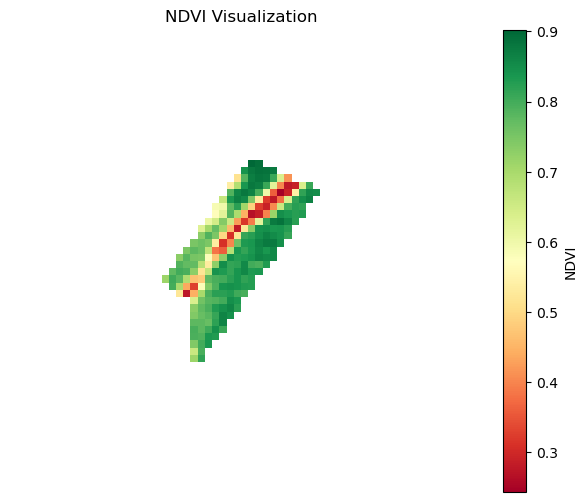

In [ ]:
test_image_sample = extracted_patches[0][0]
nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4
np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
np.unique(test_image_sample[:,:,12])

array([      0., 1226225.])

### 2th September Image - No Disease

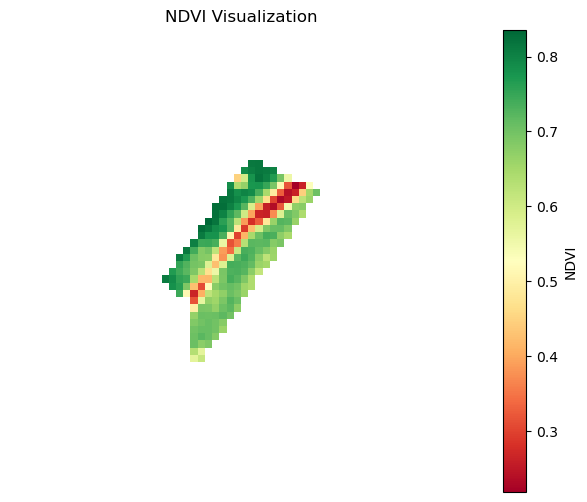

In [ ]:
test_image_sample = extracted_patches[1][0]
nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4
np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()

## Image 7 - 32_UNV_0_8 - No Disease

In [ ]:
path5='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/2019_08_08_all_bands_scl9.pkl'
path6='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/2019_07_24_all_bands_scl.pkl'
image5 = load_single_image(path5)
image6 = load_single_image(path6)
image5.shape

(11, 1000, 1000)

In [ ]:
transposed_data5 = np.transpose(image5, (2, 1, 0))
transposed_data6 = np.transpose(image6, (2, 1, 0))
transposed_data3.shape

(1000, 1000, 11)

In [ ]:
mask5='/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/fieldmask9.pkl'
fn5 = '/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Data-Sample/field_number9.pkl'
mask5 = load_single_image(mask5)
fn5 = load_single_image(fn5)
mask5.shape

(1000, 1000)

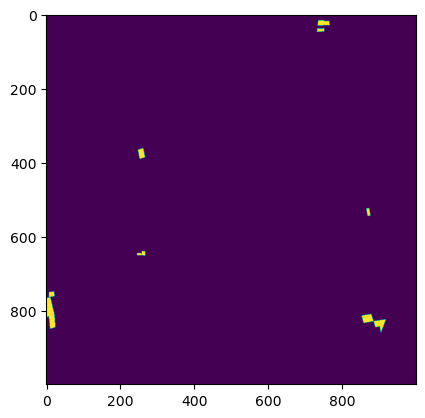

In [ ]:
plt.imshow(mask5)

In [ ]:
fn5 = np.expand_dims(fn5, axis=2)
mask5 = np.expand_dims(mask5, axis=2)

In [ ]:
np.unique(fn5)

array([      0, 1168663, 1176271, 1177274, 1196327, 1216239, 1223341,
       1224018, 1226904, 1227071, 1227074], dtype=int32)

In [ ]:
sentinel_images = [transposed_data5, transposed_data6]
sugarbeet_masks = [mask5, mask5]
fnl = [fn5, fn5]
integrated_images = integrate_sugarbeet_mask(sentinel_images, sugarbeet_masks, fnl)
masked_images = mask_images(integrated_images)
extracted_patches = extract_fields(masked_images, (64,64))

--- 996446 pixels masked in image 0
--- 996041 pixels masked in image 1
--- 8 sugar-beet fields extracted for image 0
--- 8 sugar-beet fields extracted for image 1


### 18th August Image - Without Disease

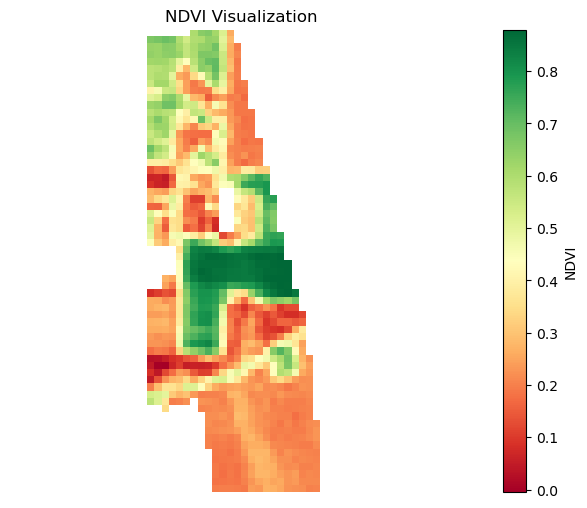

In [ ]:
test_image_sample = extracted_patches[0][6]
nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4
np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
np.unique(test_image_sample[:,:,12])

array([      0., 1226904., 1227074.])

### 2th September Image - No Disease

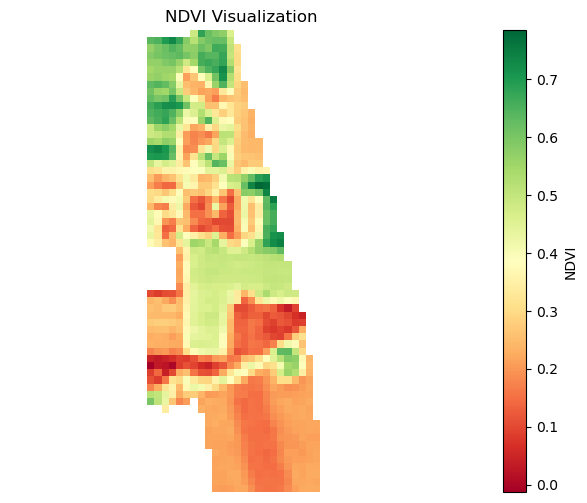

In [ ]:
test_image_sample = extracted_patches[1][6]
nir = test_image_sample[:,:,6]  # NIR -> Band 8
red = test_image_sample[:,:,2]  # Red -> Band 4
np.seterr(divide='ignore', invalid='ignore')  #Avoid division errors
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1) 
ndvi.shape
ndvi_expanded = np.expand_dims(ndvi, axis=-1)
combined_image = np.concatenate((test_image_sample, ndvi_expanded), axis=2)
combined_image.shape
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, cmap='RdYlGn')  # Use color map to visualize NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Visualization')
plt.axis('off')  # Hide axis
plt.show()